In [134]:
results_file = "fulliters_centered_priors"

In [135]:
import plotly.io as pio

interactive_plots = True
if interactive_plots is False:
    pio.renderers.default = "svg"
else:
    pio.renderers.default = "plotly_mimetype+notebook"

In [136]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from category_encoders.ordinal import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from pytorch_tabnet.tab_model import TabNetRegressor

import torch
import pyro
from pyro import distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.contrib.autoguide import AutoDiagonalNormal
from pyro.infer.autoguide.initialization import init_to_value

from tqdm.notebook import tqdm
from copy import deepcopy

import sys
sys.path.append("../src")
from preprocessing_utils import get_categs_mappings, get_emb_size
from bnn_utils import as_pyro_module, get_predictions_pyro
from metrics import get_empiric_coverage_curve, get_metrics
from plots import plot_metrics, plot_coverage_curves

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**features** and **target** definition

In [137]:
numerical_features = [
    'song_duration_ms', 
    'acousticness', 
    'danceability', 
    'energy', 
    'instrumentalness', 
    'speechiness', 
    'tempo', 
    'audio_valence',
]
categorical_features = ['key', 'audio_mode', 'time_signature']
features = categorical_features+numerical_features
target = 'song_popularity'

# Load Data
- load data
- partition data
- transform target

In [138]:
data_path = '../data/song_data.csv'

data = pd.read_csv(data_path)#.drop(['Unnamed: 0'], axis=1)

non_train_index = data.sample(frac=.2, random_state=1312).index
np.random.seed(1312)
test_index = np.random.choice(
    non_train_index, size=len(non_train_index)//2, replace=False
)
valid_index = [i for i in non_train_index if not i in test_index]

data['partition'] = "train"
data.loc[test_index, 'partition'] = "test"
data.loc[valid_index, 'partition'] = "valid"

mean = data.query('partition == "train"')[target].mean()
std = data.query('partition == "train"')[target].std()

def transform(x):
    return (x-mean)/std

def inv_transf(x):
    return std*x + mean

data[target+'_transf'] = transform(data[target])
data.loc[:, categorical_features] = data.loc[:, categorical_features].astype('category').copy()

In [139]:
data.partition.value_counts(normalize=True)

train    0.800000
valid    0.100027
test     0.099973
Name: partition, dtype: float64

# Preprocessing
feature transformation preprocessor

In [140]:
categs_mappings = get_categs_mappings(data.query("partition == 'train'"), categorical_features)

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='median', fill_value=np.NaN)), 
    ])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-999)),
    ('label', OrdinalEncoder(handle_unknown="value", mapping=categs_mappings)), #uknown values goes to -1
    ('imputer_uknow', SimpleImputer(missing_values=-1, strategy='constant', fill_value=0)), #uknown values go to 0, the index for NaN
    ])

preprocessor = ColumnTransformer(#preprocessor rearenge columns
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numerical_features)]
)


preprocessor.fit(data.query("partition == 'train'")[features])

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value=-999,
                                                                strategy='constant')),
                                                 ('label',
                                                  OrdinalEncoder(mapping=[{'col': 0,
                                                                           'mapping': {0: 1,
                                                                                       1: 2,
                                                                                       2: 3,
                                                                                       3: 4,
                                                                                       4: 5,
                                                                                       5: 6,
                             

# Define categorical embeddings

In [141]:
cat_dims = [data.query("partition == 'train'")[feature].nunique()+1 for i, feature in enumerate(categorical_features)]
cat_idxs = [i for i, f in enumerate(features) if f in categorical_features]
cat_emb_dim = [get_emb_size(n_cat) for n_cat in cat_dims]
cat_emb_dim

[7, 3, 4]

# Deterministic Model

## Model training

In [142]:
X_train = preprocessor.transform(data.query("partition == 'train'")[features])
y_train = (data.query("partition == 'train'")[target+'_transf']).values.reshape((-1, 1))

X_test = preprocessor.transform(data.query("partition == 'test'")[features])
y_test = (data.query("partition == 'test'")[target+'_transf']).values.reshape((-1, 1))

In [219]:
regressor = TabNetRegressor(
    cat_dims=cat_dims, 
    cat_emb_dim=cat_emb_dim, 
    cat_idxs=cat_idxs,
    seed=1312
)

Device used : cuda


In [220]:
max_epochs = 100
regressor.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_name=['train', 'test'],
    eval_metric=['mae'],
    max_epochs=max_epochs,
    patience=50,
    batch_size=1024,
    num_workers=0,
    drop_last=False,
)
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                       ('regressor', regressor)])

epoch 0  | loss: 1.60168 | train_mae: 0.79927 | test_mae: 0.80196 |  0:00:01s
epoch 1  | loss: 1.03212 | train_mae: 0.791   | test_mae: 0.7943  |  0:00:03s
epoch 2  | loss: 0.98418 | train_mae: 0.78063 | test_mae: 0.79038 |  0:00:04s
epoch 3  | loss: 0.97324 | train_mae: 0.78031 | test_mae: 0.79126 |  0:00:05s
epoch 4  | loss: 0.9669  | train_mae: 0.77468 | test_mae: 0.78965 |  0:00:07s
epoch 5  | loss: 0.96946 | train_mae: 0.7781  | test_mae: 0.78816 |  0:00:08s
epoch 6  | loss: 0.95906 | train_mae: 0.77266 | test_mae: 0.7816  |  0:00:10s
epoch 7  | loss: 0.95345 | train_mae: 0.77166 | test_mae: 0.78182 |  0:00:11s
epoch 8  | loss: 0.94782 | train_mae: 0.76789 | test_mae: 0.77954 |  0:00:13s
epoch 9  | loss: 0.94538 | train_mae: 0.76793 | test_mae: 0.78073 |  0:00:14s
epoch 10 | loss: 0.94813 | train_mae: 0.76568 | test_mae: 0.77952 |  0:00:16s
epoch 11 | loss: 0.94545 | train_mae: 0.76487 | test_mae: 0.77705 |  0:00:17s
epoch 12 | loss: 0.94043 | train_mae: 0.76186 | test_mae: 0.7760

## Model assesment

In [222]:
data[f'{target}_predict'] = inv_transf(pipeline.predict(data[features]))
data['error'] = data.eval(f'{target}_predict- {target}')
data['perc_error'] = data.eval(f'error/{target}')
data['abs_perc_error'] = data.eval('abs(perc_error)')

<AxesSubplot:>

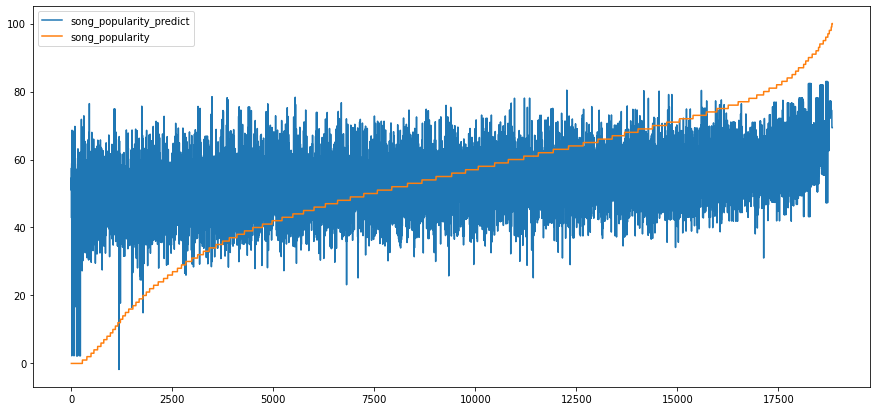

In [224]:
cols = [f'{target}_predict', target]
(
    data[cols]
    .sort_values(by=target)
    .reset_index(drop=True)
    .plot(figsize=(15, 7))
)

In [146]:
ape_metrics = data.groupby('partition').abs_perc_error.agg(
    MAPE=lambda x: np.mean(x[x<np.infty]), MedianAPE= np.median
)

ae_metrics = data.groupby('partition').error.agg(
    MAE=lambda x: np.mean(abs(x)), MedianAE=lambda x: np.median(abs(x))
)

model_metrics = pd.concat([ape_metrics, ae_metrics], axis=1)
round(model_metrics, 2)

,MAPE,MedianAPE,MAE,MedianAE
partition,,,,
test,1.05,0.23,16.59,13.82
train,1.02,0.22,15.75,13.14
valid,0.96,0.23,16.47,13.90


# BNN model

In [147]:
pyro.set_rng_seed(1312)

## Prior definition

In [148]:
bayesian_layers = ['tabnet.final_mapping']
non_bayesian_layers = [
    name for name, _ in regressor.network.named_modules()
    if not name in bayesian_layers
]

In [149]:
net = deepcopy(regressor.network)
bayes_net = as_pyro_module(
    net, 
    scale=1, 
    tabnet_centered=False, 
    forbidden_names=non_bayesian_layers
)
trained_weights = regressor.network.state_dict()

## Model definition

In [150]:
batch_size = 1024

device = regressor.device
one = torch.ones(1).to(device)
zero = torch.ones(1).to(device)

#original
def model(x, y=None):
    
    #define priors
    preds = net(x)[0]
    sigma = 0.5*one
    
    #likelihood:
    if y is not None:
        with pyro.plate('observe_data', size=len(y), subsample_size=batch_size, device=device) as ind:
            pyro.sample('obs', dist.Normal(preds.index_select(0, ind), sigma).to_event(1), 
                        obs=y.index_select(0, ind))
    
    return preds

## Model training

In [157]:
init_scale = 40.0

guide = AutoDiagonalNormal(
    model, 
    init_loc_fn=init_to_value(values=trained_weights), 
    init_scale=init_scale
)
optim = Adam({"lr": 0.001})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

### We check how inital model is doing
we use a sample of 10% of the data for the assesments since the full data set is to big to allocate all the samples for all the rows

In [158]:
data_sample = pd.concat(
    [
        df.sample(frac=0.1,  random_state=1312) 
        for name, df in data.groupby('partition')
    ]
)

In [159]:
preds = get_predictions_pyro(    
    model, 
    guide,
    preprocessor,
    features,
    data_sample, 
    n_samples=500, 
    varbls=['_RETURN'],
    device=device,
)['_RETURN']

coverage_curves = get_empiric_coverage_curve(
    preds,
    data_sample,
    target,
    inv_transf,
    coverages=np.linspace(.001, .999, 50)
)

metrics = get_metrics(
    model, 
    guide, 
    data_sample, 
    features, 
    target, 
    preprocessor, 
    inv_transf, 
    n_samples=500,
    device=device,
)

round(metrics, 2)

,MAPE,MAE,emp_coverage_80pct,perc_lenght_80pct,abs_lenght_80pct,confidence_error
partition,,,,,,
test,0.95,17.26,0.72,2.24,57.69,0.07
train,0.90,15.63,0.75,1.79,55.94,0.06
valid,1.19,16.98,0.72,2.34,53.98,0.12


In [160]:
fig = plot_coverage_curves(coverage_curves)
fig.show()

In [161]:
%%time
X_train_torch = torch.Tensor(X_train).to(device)
y_train_torch = torch.Tensor(y_train).to(device)

pyro.clear_param_store()
num_iterations = 20
metrics_list = []

for i in tqdm(range(num_iterations), total=num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(X_train_torch, y_train_torch)
    metrics = get_metrics(
        model, 
        guide, 
        data_sample, 
        features, 
        target, 
        preprocessor, 
        inv_transf, 
        n_samples=100,
        device=device,
    )   
    
    metrics.loc['train', 'elbo'] = loss
    metrics = (
        metrics
        .unstack()
        .dropna()
        .to_frame('value')
        .reset_index()
        .rename(columns={'level_0': 'metric'})
    )
    metrics['iteration'] = i
    metrics_list.append(metrics)
    results = pd.concat(metrics_list)

results.to_csv(f'results/{results_file}.csv')


  0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 5min 24s, sys: 253 ms, total: 5min 24s
Wall time: 1min 49s


In [22]:
#results = pd.read_csv(f'results/{results_file}.csv')

## Training assesment

In [162]:
fig_list = plot_metrics(results)
for fig in fig_list: fig.show()

## Model assesment

### Coverage curves

In [209]:
preds = get_predictions_pyro(    
    model, 
    guide,
    preprocessor,
    features,
    data_sample, 
    n_samples=500, 
    varbls=['_RETURN'],
    device=device
)['_RETURN']

coverage_curves = get_empiric_coverage_curve(
    preds,
    data_sample,
    target,
    inv_transf,
    coverages=np.linspace(.001, .999, 50)
)

preds_transf = inv_transf(preds.squeeze())
data_sample.loc[:, ['q10', 'q90']] = np.quantile(preds_transf, [0.1, 0.9], axis=0).T

<AxesSubplot:>

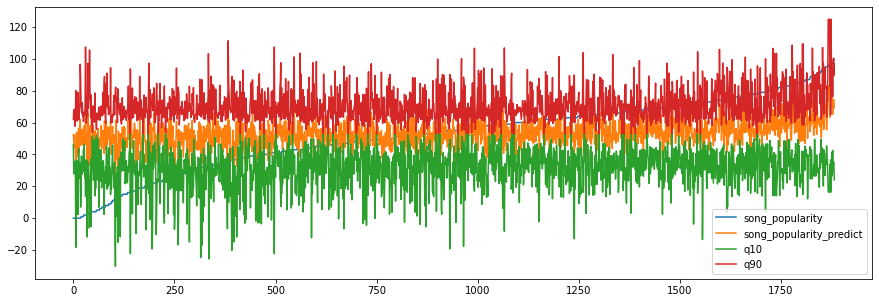

In [217]:
cols = [target, f'{target}_predict', 'q10', 'q90']
data_sample[cols].sort_values(by=target).reset_index(drop=True).plot(figsize=(15, 5))

In [ ]:
fig = plot_coverage_curves(coverage_curves)
fig.show()

## Other metrics

In [ ]:
metrics = get_metrics(
    model, 
    guide, 
    data_sample, 
    features, 
    target, 
    preprocessor, 
    inv_transf, 
    n_samples=500
)

round(metrics, 2)